## Helper functions

In [17]:
"""Imports"""
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from cot import Collection
import yaml

In [18]:
# Helper functions to call OpenAI model, system also generates reasoning
# this function lets the model reason (less frequently used than system_evaluate)

def system_experiment(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\nwith the following answer options:{answer_options}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_generate(input_dict)

def save_as_yaml(data, filepath):
    with open(filepath, 'w') as file:
        yaml.dump(data, file)

In [19]:
def system_evaluate(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\n
    with the following answer options:{answer_options}\n
    Reasoning: {reasoning}\n
    Answer: {answer}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_evals(input_dict)

In [20]:
def count_keys(lst):

    counts = {}
    for item in lst:
        if isinstance(item, list):
            sub_counts = count_keys(item)
            for key, value in sub_counts.items():
                counts[key] = counts.get(key, 0) + value
        else:
            counts[item] = counts.get(item, 0) + 1
    return counts

In [21]:
import yaml
def parse_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    lowest_obj = []
    scores_with_indicator = []
    for item in new_data[dataset][split]:
        flag = False
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                #scores_per_item.append(new_dict)
                flag = True
                variables_per_item.append(data)
        except:
            print("wrong output found")
            continue

        if flag == True:
            data = new_dict
            
            try:
                # Find the lowest value
                lowest_value = min(data.values())

                # Calculate the average value
                average_value = sum(data.values()) / len(data)

                # Find the key(s) of the lowest value
                lowest_keys = [key for key, value in data.items() if value == lowest_value]     
                lowest_obj.append(lowest_keys)

                # Add lowest and average values to the dictionary
                data['lowest'] = lowest_value
                data['average'] = average_value
            except:
                data['lowest'] = 'None'
                data['average'] = 'None'
                lowest_obj.append('None')
                print("non_int data found... continue")
                print(data)

            scores_per_item.append(data)
            scores_with_indicator.append((data,item['generated_cot'][0]['answers'][0]['correct_answer']))

    #filter for strings
    lowest_tuples = []
    for i in range(len(lowest_obj)):
        lowest_tuples.append((lowest_obj[i],scores_with_indicator[i][1]))
    print(lowest_tuples[0])
    filtered_lowest_tuples = [score_tuple for score_tuple in lowest_tuples if not any(isinstance(value, str) for value in score_tuple[0])]
         
    return scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator

In [22]:
def get_further_data(scores_per_item):
# Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys}

    # #check values for nonetype
    # for key, value in scores_per_objective.items():
    #     if value is not str:
    #         #print(key,value)
    #         continue

    averaged_data = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in scores_per_objective.items() if len([v for v in value if v is not None]) > 0}

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_objective, df

In [23]:
def fix_str_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if isinstance(value,str):
                scores_per_item.pop(i)
    return scores_per_item

In [24]:
def compare_true_false(obj_scores_true,obj_scores_false,p_val_dict):

    averaged_true = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in obj_scores_true.items() if len([v for v in value if v is not None]) > 0}
    averaged_false = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in obj_scores_false.items() if len([v for v in value if v is not None]) > 0}


    # Convert the averaged data dictionary to a Pandas DataFrame
    df_true = pd.DataFrame.from_dict(averaged_true, orient='index', columns=['Average'])
    df_false = pd.DataFrame.from_dict(averaged_false, orient='index', columns=['Average'])
    df_p_val = pd.DataFrame.from_dict(p_val_dict, orient='index', columns=['P-value'])

    # Sort the DataFrame by the index (row labels)
    df_true = df_true.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11','average']]
    df_false = df_false.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11','average']]
    df_p_val = df_p_val.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11','average']]
    # Rename the 'Average' column in each dataframe
    df_true.rename(columns={'Average': 'Average_true'}, inplace=True)
    df_false.rename(columns={'Average': 'Average_false'}, inplace=True)

    # Concatenate the dataframes horizontally along the columns
    merged_df = pd.concat([df_true, df_false,df_p_val], axis=1)

    merged_df['Difference'] = merged_df['Average_true'] - merged_df['Average_false']

    # Get the list of column names
    columns = merged_df.columns.tolist()

    # Swap the positions of the last two columns
    columns[-1], columns[-2] = columns[-2], columns[-1]

    # Reindex the DataFrame with the updated column order
    merged_df = merged_df.reindex(columns=columns)

  

    return merged_df

In [25]:
#helper functions for results
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statistics

def freq_bar_plot(scores_per_item): #later better axes
    average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
    # Create a histogram
    plt.hist(average_per_item, bins='auto', alpha=0.7)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Frequency of average score per item')
    plt.show()

def avg_true_false(data,average_per_item,dataset,split):
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = average_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    print("scores true:", statistics.mean(scores_true))
    print("scores false:", statistics.mean(scores_false))


In [26]:
import math

def standard_deviation(data):
    # First, compute the mean for each key.
    mean_data = {key: sum(value) / len(value) for key, value in data.items()}
    
    # Then, for each key, compute the sum of the squared differences from the mean.
    variance_data = {}
    for key, value in data.items():
        variance_data[key] = sum((x - mean_data[key]) ** 2 for x in value) / (len(value)-1)
    
    # Finally, compute the standard deviation for each key.
    standard_deviation_data = {key: math.sqrt(value) for key, value in variance_data.items()}
    
    return standard_deviation_data

In [41]:
from scipy.stats import mannwhitneyu

def u_test(scores_with_indicator):

    #filter for strings
    filtered_scores_with_indicator = [score_tuple for score_tuple in scores_with_indicator if not any(isinstance(value, str) for value in score_tuple[0].values())]
    

    scores, indicators= zip(*filtered_scores_with_indicator)

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    keys = set().union(*scores_true)
        # Create lists of values for each key
    scores_per_objective_true = {key: [d.get(key) for d in scores_true] for key in keys if key != "critique"} 

    keys = set().union(*scores_false)
        # Create lists of values for each key
    scores_per_objective_false = {key: [d.get(key) for d in scores_false] for key in keys if key != "critique"} 

    dict_1 = scores_per_objective_true
    dict_2 = scores_per_objective_false

    # make sure both dictionaries have the same keys
    print(dict_1.keys())
    print('\n')
    print(dict_2.keys())


    assert dict_1.keys() == dict_2.keys()

    

    p_val_dict = dict()
    for key in dict_1.keys():
        u_stat, p_val = mannwhitneyu(dict_1[key], dict_2[key])
        print(f"For {key}, U-statistic is {u_stat:.2f} and the p-value is {p_val:.2f}")
        p_val_dict[key]= round(p_val,3)
    return scores_per_objective_true,scores_per_objective_false, p_val_dict

In [28]:
import copy
"""Only use if none ans should not be false"""
def generate_without_none_ans(data):
    all_data = copy.deepcopy(data)
    true_data = copy.deepcopy(data)
    false_data = copy.deepcopy(data)


    false_data.evaluate()
    false_data.select_generated_cots(answer=False)
    false_data = false_data.filter(lambda x: len(x["generated_cot"])==1)

    true_data.evaluate()
    true_data.select_generated_cots(answer=True)
    true_data = true_data.filter(lambda x: len(x["generated_cot"])==1)

    full_data = false_data.merge(true_data)

    ids = full_data.dump_ids()

    # print(len(ids))

    # print(all_data)

    none_data = all_data.filter(lambda ex: ex['id'] not in ids)

    # print(none_data)

    none_ids = none_data.dump_ids()

    return all_data.filter(lambda ex: ex['id'] not in none_ids)



In [ ]:
#Remove CoTs 
"""
import json

# Assuming the JSON data is stored in a string variable named `json_str`

with open("./med_qa_first_gpt-3.5-turbo-0613_gpt-3.5-turbo-0613.json", 'r') as f:
    data = json.load(f)


#data = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-4.json")
# Loop through each test item
for test_item in data['med_qa']['test']:
    # Remove the second element of 'generated_cot' list
    if len(test_item['generated_cot']) > 2:
        del test_item['generated_cot'][1]

# Now you can convert the data back to a JSON string if needed
modified_json_str = json.dumps(data)

with open('modified_turbo-0613.json', 'w') as json_file:
    json.dump(data, json_file)
"""

In [ ]:
import json

# # Assuming the JSON data is stored in a string variable named `json_str`
# #data = json.loads()

# with open("./med_qa_first_gpt-3.5-turbo_gpt-4.json", 'r') as f:
#     data = json.load(f)


# #data = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-4.json")
# # Loop through each test item
# for test_item in data['med_qa']['test']:
#     # Remove the second element of 'generated_cot' list
#     if len(test_item['generated_cot']) > 1:
#         del test_item['generated_cot'][1]

# # Now you can convert the data back to a JSON string if needed
# modified_json_str = json.dumps(data)

# with open('modified_medqa.json', 'w') as json_file:
#     json.dump(data, json_file)

In [29]:
import pandas as pd

In [15]:
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "openai_chat",
    "api_time_interval": 1,
    "engine": "gpt-3.5-turbo", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)
med_qa.dump("med_qa_400_turbo")
med_qa.evaluate()
med_qa.dump("med_qa_400_turbo_eval")
med_qa.evaluate()


KeyboardInterrupt



In [43]:
path = "./final_system_messages/first_template.yaml"

## Run reflection

In [ ]:
# 3.5 on 3.5
data = med_qa
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

In [ ]:
#Other reflection were run in big_reflection_experiments.ipynb

## Evaluate reflection

### GPT-4 supervised by GPT-3.5

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

non_int data found... continue
{'obj_1': 100, 'obj_2': 100, 'obj_3': 'N/A', 'obj_4': 100, 'obj_5': 100, 'obj_6': 100, 'obj_7': 100, 'obj_8': 100, 'obj_9': 100, 'obj_10': 100, 'obj_11': 100, 'lowest': 'None', 'average': 'None'}
non_int data found... continue
{'obj_1': 'The reasoning accurately breaks down the question into smaller parts and analyzes each possible outcome.', 'obj_2': 'The reasoning considers all relevant information and does not consider irrelevant information.', 'obj_3': 'The reasoning accurately interprets and incorporates the numerical information provided by the user.', 'obj_4': 'The reasoning considers all relevant reasoning strategies and selects the most appropriate reasoning strategy, but could benefit from more detailed explanations of the biochemical processes involved.', 'obj_5': 'The reasoning is structured through reasoning steps, but could benefit from more sub-questions to further break down the analysis.', 'obj_6': 'The reasoning gives appropriate priorit

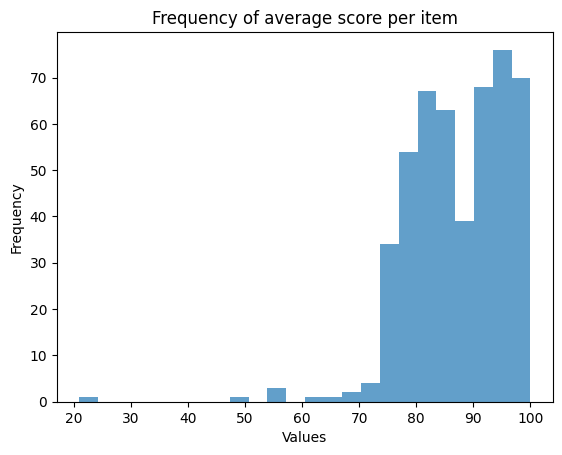

Mann-Whitney-U test
dict_keys(['obj_7', 'obj_1', 'obj_5', 'obj_3', 'lowest', 'obj_11', 'obj_6', 'obj_10', 'obj_8', 'average', 'obj_2', 'obj_9', 'obj_4'])
For obj_7, U-statistic is 21946.00 and the p-value is 0.30
For obj_1, U-statistic is 21039.50 and the p-value is 0.74
For obj_5, U-statistic is 20001.00 and the p-value is 0.62
For obj_3, U-statistic is 23401.00 and the p-value is 0.02
For lowest, U-statistic is 21382.50 and the p-value is 0.55
For obj_11, U-statistic is 23068.00 and the p-value is 0.02
For obj_6, U-statistic is 22416.00 and the p-value is 0.16
For obj_10, U-statistic is 21731.00 and the p-value is 0.38
For obj_8, U-statistic is 22342.50 and the p-value is 0.16
For average, U-statistic is 22156.00 and the p-value is 0.24
For obj_2, U-statistic is 22698.00 and the p-value is 0.06
For obj_9, U-statistic is 21709.00 and the p-value is 0.39
For obj_4, U-statistic is 22771.50 and the p-value is 0.09
range of scores
{'obj_7': (30, 100), 'obj_1': (30, 100), 'obj_5': (40, 100

,Average_true,Average_false,Difference,P-value
obj_1,90.190840,89.904762,0.286078,0.740
obj_2,96.335878,95.047619,1.288259,0.057
obj_3,92.748092,90.666667,2.081425,0.023
obj_4,89.592875,87.952381,1.640494,0.086
obj_5,83.307888,83.809524,-0.501636,0.620
obj_6,85.992366,84.666667,1.325700,0.156
obj_7,85.496183,84.190476,1.305707,0.300
obj_8,92.519084,91.428571,1.090513,0.155
obj_9,76.513995,75.523810,0.990185,0.387
obj_10,87.506361,86.571429,0.934933,0.378


In [44]:
import pandas as pd
from cot import Collection
data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-3.5-turbo.json")
data_100 = Collection.from_json("./med_qa_100_first_gpt-4_gpt-3.5-turbo.json")
data_500 = data_400.merge(data_100)
data = data_500

scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
print("\n")
print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false, df_p_val = u_test(scores_with_indicator)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
df = compare_true_false(scores_per_objective_true,scores_per_objective_false,df_p_val)
df.to_excel('table_1.xlsx', index=False)
df

### New GPT-3.5 supervises GPT-4



wrong output found
(['obj_9'], True)
Average over objectives for all items
          Average
obj_1   94.569138
obj_2   93.286573
obj_3   88.577154
obj_4   89.098196
obj_5   87.114228
obj_6   86.913828
obj_7   84.719439
obj_8   92.274549
obj_9   81.693387
obj_10  89.498998
obj_11  93.907816




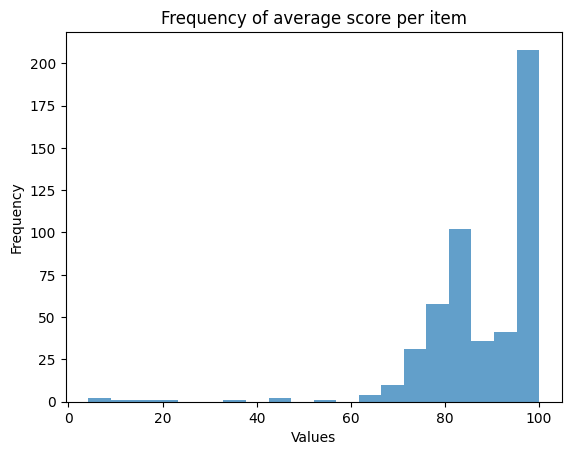

Mann-Whitney-U test
dict_keys(['obj_3', 'obj_5', 'average', 'obj_1', 'obj_10', 'obj_6', 'lowest', 'obj_9', 'obj_11', 'obj_4', 'obj_7', 'obj_8', 'obj_2'])
For obj_3, U-statistic is 24896.50 and the p-value is 0.00
For obj_5, U-statistic is 23303.50 and the p-value is 0.04
For average, U-statistic is 23932.50 and the p-value is 0.01
For obj_1, U-statistic is 23461.50 and the p-value is 0.02
For obj_10, U-statistic is 23894.00 and the p-value is 0.01
For obj_6, U-statistic is 23590.50 and the p-value is 0.02
For lowest, U-statistic is 23501.50 and the p-value is 0.02
For obj_9, U-statistic is 23651.50 and the p-value is 0.02
For obj_11, U-statistic is 24079.50 and the p-value is 0.00
For obj_4, U-statistic is 23447.50 and the p-value is 0.02
For obj_7, U-statistic is 23206.50 and the p-value is 0.05
For obj_8, U-statistic is 23893.00 and the p-value is 0.01
For obj_2, U-statistic is 23000.00 and the p-value is 0.05
range of scores
{'obj_3': (0, 100), 'obj_5': (0, 100), 'average': (4.54545

,Average_true,Average_false,Difference,P-value
obj_1,94.822335,93.619048,1.203287,0.016
obj_2,93.527919,92.380952,1.146966,0.048
obj_3,89.454315,85.285714,4.168600,0.001
obj_4,89.530457,87.476190,2.054266,0.024
obj_5,87.538071,85.523810,2.014262,0.035
obj_6,87.487310,84.761905,2.725405,0.020
obj_7,85.304569,82.523810,2.780759,0.046
obj_8,92.715736,90.619048,2.096688,0.008
obj_9,82.563452,78.428571,4.134880,0.018
obj_10,90.139594,87.095238,3.044356,0.009


In [31]:

data = Collection.from_json("./med_qa_first_gpt-4_gpt-3.5-turbo-0613.json")
print("\n")
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false, df_p_val = u_test(scores_with_indicator)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
df = compare_true_false(scores_per_objective_true,scores_per_objective_false,df_p_val)
df

### GPT-3.5 supervised by GPT-4

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

(['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11'], True)


Average over objectives for all items
        Average
obj_1     97.08
obj_2     90.62
obj_3     98.70
obj_4     90.81
obj_5     94.61
obj_6     92.42
obj_7     83.88
obj_8     88.34
obj_9     88.44
obj_10    93.43
obj_11    87.40




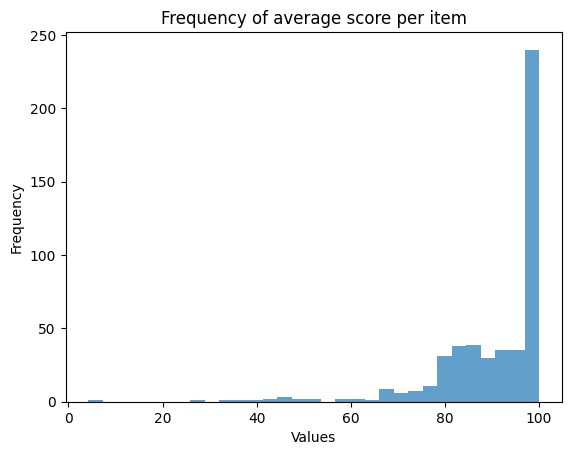

Mann-Whitney-U test
dict_keys(['obj_11', 'obj_10', 'obj_6', 'obj_2', 'lowest', 'obj_3', 'obj_1', 'obj_9', 'obj_8', 'obj_7', 'average', 'obj_4', 'obj_5'])
For obj_11, U-statistic is 42142.00 and the p-value is 0.00
For obj_10, U-statistic is 45195.00 and the p-value is 0.00
For obj_6, U-statistic is 44201.00 and the p-value is 0.00
For obj_2, U-statistic is 46999.50 and the p-value is 0.00
For lowest, U-statistic is 50663.50 and the p-value is 0.00
For obj_3, U-statistic is 31590.00 and the p-value is 0.01
For obj_1, U-statistic is 40579.00 and the p-value is 0.00
For obj_9, U-statistic is 34466.00 and the p-value is 0.01
For obj_8, U-statistic is 50260.50 and the p-value is 0.00
For obj_7, U-statistic is 42664.50 and the p-value is 0.00
For average, U-statistic is 49846.00 and the p-value is 0.00
For obj_4, U-statistic is 46503.50 and the p-value is 0.00
For obj_5, U-statistic is 41250.00 and the p-value is 0.00
range of scores
{'obj_11': (0, 100), 'obj_10': (0, 100), 'obj_6': (0, 100)

,Average_true,Average_false,Difference,P-value
obj_1,98.979592,94.368932,4.610660,0.000
obj_2,95.595238,83.519417,12.075821,0.000
obj_3,99.557823,97.475728,2.082095,0.013
obj_4,96.360544,82.888350,13.472195,0.000
obj_5,97.363946,90.679612,6.684334,0.000
obj_6,96.598639,86.456311,10.142329,0.000
obj_7,88.197279,77.718447,10.478832,0.000
obj_8,95.969388,77.451456,18.517931,0.000
obj_9,91.020408,84.757282,6.263127,0.005
obj_10,97.653061,87.402913,10.250149,0.000


In [31]:
data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-4.json")
data_100 = Collection.from_json("./modified_first_gpt-3.5-turbo_gpt-4.json")
data_500 = data_400.merge(data_100)
data = data_500
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
print("\n")
print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false, df_p_val = u_test(scores_with_indicator)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
df = compare_true_false(scores_per_objective_true,scores_per_objective_false,df_p_val)
df.to_excel('table_2.xlsx', index=False)
df

### GPT-3.5 supervised by GPT-3.5

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

wrong output found
non_int data found... continue
{'obj_1': '100%', 'obj_2': '100%', 'obj_3': '100%', 'obj_4': '90%', 'obj_5': '90%', 'obj_6': '90%', 'obj_7': '80%', 'obj_8': '90%', 'obj_9': '80%', 'obj_10': '90%', 'obj_11': '100%', 'lowest': 'None', 'average': 'None'}
(['obj_4'], True)


Average over objectives for all items
          Average
obj_1   88.898964
obj_2   95.401554
obj_3   90.272021
obj_4   87.655440
obj_5   82.111399
obj_6   85.142487
obj_7   84.028497
obj_8   91.489637
obj_9   77.020725
obj_10  86.917098
obj_11  94.974093




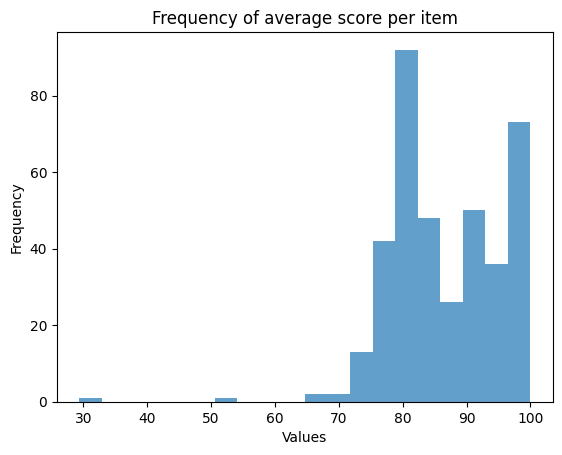

Mann-Whitney-U test
dict_keys(['obj_7', 'obj_1', 'obj_5', 'obj_3', 'lowest', 'obj_11', 'obj_6', 'obj_10', 'obj_8', 'average', 'obj_2', 'obj_9', 'obj_4'])
For obj_7, U-statistic is 21708.50 and the p-value is 0.02
For obj_1, U-statistic is 21567.50 and the p-value is 0.02
For obj_5, U-statistic is 21594.50 and the p-value is 0.03
For obj_3, U-statistic is 21682.00 and the p-value is 0.02
For lowest, U-statistic is 22172.00 and the p-value is 0.00
For obj_11, U-statistic is 22388.50 and the p-value is 0.00
For obj_6, U-statistic is 21714.50 and the p-value is 0.02
For obj_10, U-statistic is 22098.00 and the p-value is 0.01
For obj_8, U-statistic is 22116.00 and the p-value is 0.00
For average, U-statistic is 22543.00 and the p-value is 0.00
For obj_2, U-statistic is 21118.00 and the p-value is 0.04
For obj_9, U-statistic is 21255.50 and the p-value is 0.05
For obj_4, U-statistic is 22899.00 and the p-value is 0.00
range of scores
{'obj_7': (50, 100), 'obj_1': (50, 100), 'obj_5': (50, 100

,Average_true,Average_false,Difference,P-value
obj_1,89.680851,87.361963,2.318888,0.022
obj_2,95.808511,94.662577,1.145934,0.044
obj_3,91.021277,88.834356,2.186921,0.019
obj_4,89.021277,85.429448,3.591829,0.000
obj_5,83.106383,80.306748,2.799635,0.025
obj_6,86.063830,83.619632,2.444198,0.017
obj_7,85.042553,82.208589,2.833964,0.019
obj_8,92.425532,90.061350,2.364182,0.004
obj_9,77.936170,75.306748,2.629422,0.050
obj_10,87.829787,85.276074,2.553714,0.005


In [51]:


data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_500 = data_400.merge(data_100)
data = data_500

scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
print("\n")
print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false, df_p_val = u_test(scores_with_indicator)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
df = compare_true_false(scores_per_objective_true,scores_per_objective_false,df_p_val)
df.to_excel('table_3.xlsx', index=False)
df

### New GPT-3.5 supervises old gpt-3.5



(['obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_9'], True)
Average over objectives for all items
        Average
obj_1     94.58
obj_2     93.25
obj_3     88.42
obj_4     89.37
obj_5     87.24
obj_6     87.27
obj_7     85.53
obj_8     92.44
obj_9     81.47
obj_10    89.76
obj_11    93.64




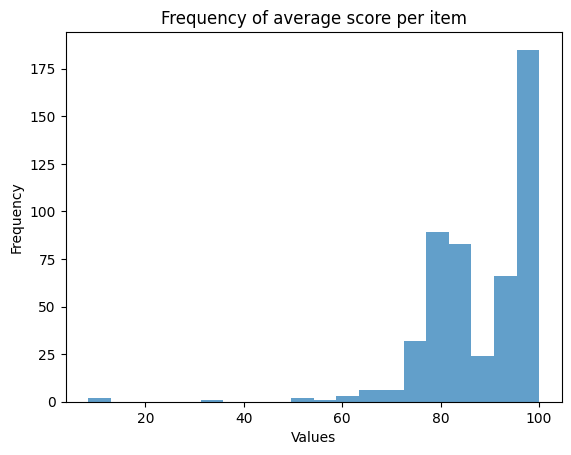

Mann-Whitney-U test
dict_keys(['obj_3', 'obj_5', 'average', 'obj_1', 'obj_10', 'obj_6', 'lowest', 'obj_9', 'obj_11', 'obj_4', 'obj_7', 'obj_8', 'obj_2'])
For obj_3, U-statistic is 36449.00 and the p-value is 0.00
For obj_5, U-statistic is 36661.50 and the p-value is 0.00
For average, U-statistic is 37432.00 and the p-value is 0.00
For obj_1, U-statistic is 36185.00 and the p-value is 0.00
For obj_10, U-statistic is 36825.50 and the p-value is 0.00
For obj_6, U-statistic is 36831.50 and the p-value is 0.00
For lowest, U-statistic is 37027.00 and the p-value is 0.00
For obj_9, U-statistic is 36573.00 and the p-value is 0.00
For obj_11, U-statistic is 35437.50 and the p-value is 0.00
For obj_4, U-statistic is 36169.00 and the p-value is 0.00
For obj_7, U-statistic is 36593.50 and the p-value is 0.00
For obj_8, U-statistic is 36580.50 and the p-value is 0.00
For obj_2, U-statistic is 35946.50 and the p-value is 0.00
range of scores
{'obj_3': (0, 100), 'obj_5': (0, 100), 'average': (9.09090

,Average_true,Average_false,Difference,P-value
obj_1,95.816327,92.815534,3.000793,0.0
obj_2,94.523810,91.432039,3.091771,0.0
obj_3,90.340136,85.679612,4.660524,0.0
obj_4,91.139456,86.844660,4.294796,0.0
obj_5,89.166667,84.490291,4.676375,0.0
obj_6,89.285714,84.393204,4.892510,0.0
obj_7,87.636054,82.524272,5.111783,0.0
obj_8,93.843537,90.436893,3.406644,0.0
obj_9,84.200680,77.572816,6.627865,0.0
obj_10,91.581633,87.160194,4.421438,0.0


In [30]:
data = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-3.5-turbo-0613.json")
print("\n")
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false, df_p_val = u_test(scores_with_indicator)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
df = compare_true_false(scores_per_objective_true,scores_per_objective_false,df_p_val)
df


### New GPT-3.5 supervises new gpt-3.5

  0%|          | 0/500 [00:00<?, ?ex/s]



wrong output found
wrong output found
wrong output found
wrong output found
(['obj_4', 'obj_6', 'obj_9'], False)
Average over objectives for all items
          Average
obj_1   94.415323
obj_2   93.014113
obj_3   89.657258
obj_4   89.627016
obj_5   88.497984
obj_6   87.983871
obj_7   86.431452
obj_8   92.308468
obj_9   83.356855
obj_10  90.120968
obj_11  92.963710




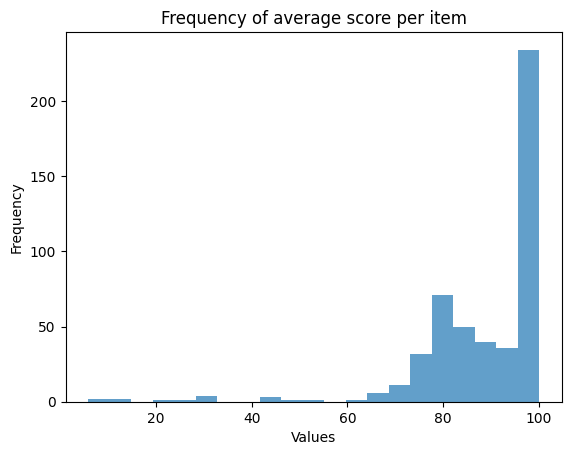

Mann-Whitney-U test
dict_keys(['obj_3', 'obj_5', 'average', 'obj_1', 'obj_10', 'obj_6', 'lowest', 'obj_9', 'obj_11', 'obj_4', 'obj_7', 'obj_8', 'obj_2'])


dict_keys(['obj_3', 'obj_5', 'average', 'obj_1', 'obj_10', 'obj_6', 'lowest', 'obj_9', 'obj_11', 'obj_4', 'obj_7', 'obj_8', 'obj_2'])
For obj_3, U-statistic is 34392.00 and the p-value is 0.00
For obj_5, U-statistic is 33667.00 and the p-value is 0.00
For average, U-statistic is 34510.50 and the p-value is 0.00
For obj_1, U-statistic is 34136.00 and the p-value is 0.00
For obj_10, U-statistic is 33903.00 and the p-value is 0.00
For obj_6, U-statistic is 34226.50 and the p-value is 0.00
For lowest, U-statistic is 33932.50 and the p-value is 0.00
For obj_9, U-statistic is 33996.00 and the p-value is 0.00
For obj_11, U-statistic is 35499.50 and the p-value is 0.00
For obj_4, U-statistic is 34183.50 and the p-value is 0.00
For obj_7, U-statistic is 33482.00 and the p-value is 0.00
For obj_8, U-statistic is 34491.50 and the p-value is 0.

,Average_true,Average_false,Difference,P-value
obj_1,96.136364,91.595745,4.540619,0.000
obj_2,94.448052,90.664894,3.783158,0.000
obj_3,92.110390,85.638298,6.472092,0.000
obj_4,91.915584,85.877660,6.037925,0.000
obj_5,90.373377,85.425532,4.947845,0.001
obj_6,90.292208,84.202128,6.090080,0.000
obj_7,88.603896,82.872340,5.731556,0.002
obj_8,94.415584,88.856383,5.559201,0.000
obj_9,86.006494,79.015957,6.990536,0.001
obj_10,92.467532,86.276596,6.190937,0.001


In [43]:
data = Collection.from_json("./modified_turbo-0613.json")
data.evaluate()
print("\n")
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false, df_p_val = u_test(scores_with_indicator)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
df = compare_true_false(scores_per_objective_true,scores_per_objective_false,df_p_val)
df



### GPT-4 supervised by GPT-4

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]



(['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11'], False)
Average over objectives for all items
        Average
obj_1     99.45
obj_2     97.65
obj_3     99.82
obj_4     98.24
obj_5     99.09
obj_6     98.41
obj_7     89.90
obj_8     97.78
obj_9     92.97
obj_10    98.96
obj_11    97.78




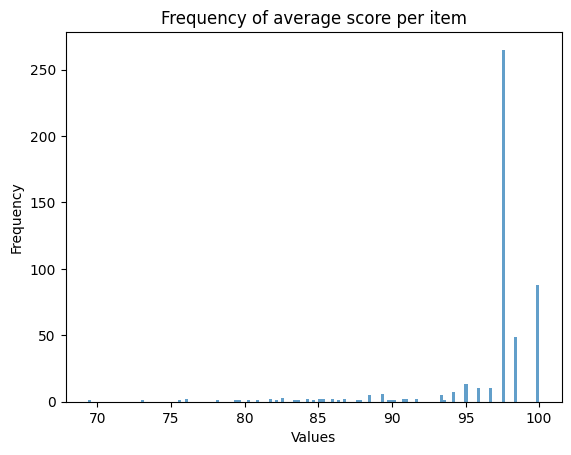

Mann-Whitney-U test
dict_keys(['obj_7', 'obj_1', 'obj_5', 'obj_3', 'lowest', 'obj_11', 'obj_6', 'obj_10', 'obj_8', 'average', 'obj_2', 'obj_9', 'obj_4'])
For obj_7, U-statistic is 25066.50 and the p-value is 0.00
For obj_1, U-statistic is 22583.00 and the p-value is 0.00
For obj_5, U-statistic is 22624.50 and the p-value is 0.00
For obj_3, U-statistic is 20883.00 and the p-value is 0.31
For lowest, U-statistic is 25841.50 and the p-value is 0.00
For obj_11, U-statistic is 22806.00 and the p-value is 0.00
For obj_6, U-statistic is 24844.00 and the p-value is 0.00
For obj_10, U-statistic is 23527.50 and the p-value is 0.00
For obj_8, U-statistic is 25495.50 and the p-value is 0.00
For average, U-statistic is 26231.50 and the p-value is 0.00
For obj_2, U-statistic is 24847.50 and the p-value is 0.00
For obj_9, U-statistic is 20835.50 and the p-value is 0.93
For obj_4, U-statistic is 24507.50 and the p-value is 0.00
range of scores
{'obj_7': (50, 100), 'obj_1': (80, 100), 'obj_5': (70, 100

,Average_true,Average_false,Difference,P-value
obj_1,99.658228,98.666667,0.991561,0.000
obj_2,98.354430,95.000000,3.354430,0.000
obj_3,99.924051,99.428571,0.495479,0.313
obj_4,98.924051,95.666667,3.257384,0.000
obj_5,99.316456,98.238095,1.078360,0.001
obj_6,99.012658,96.142857,2.869801,0.000
obj_7,90.708861,86.857143,3.851718,0.000
obj_8,98.696203,94.333333,4.362869,0.000
obj_9,93.050633,92.666667,0.383966,0.932
obj_10,99.341772,97.523810,1.817963,0.000


In [49]:

data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-4_gpt-4.json")
data_500 = data_400.merge(data_100)
data = data_500
print("\n")
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false, df_p_val = u_test(scores_with_indicator)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
df = compare_true_false(scores_per_objective_true,scores_per_objective_false,df_p_val)
df.to_excel('table_4.xlsx', index=False)
df

### Cohere supervised by GPT-3.5-turbo

non_int data found... continue
{'obj_1': 'The reasoning accurately identifies that the patient has had a stroke, but does not provide a detailed breakdown of the question.', 'obj_2': 'The reasoning considers the relevant information and does not include irrelevant information.', 'obj_3': "The reasoning does not incorporate the numerical information provided by the user, such as the patient's blood pressure and pulse rate.", 'obj_4': 'The reasoning only considers one reasoning strategy, which is the most common cause of a stroke, but does not consider other possible causes or differential diagnoses.', 'obj_5': 'The reasoning is not structured and lacks detail, such as sub-questions or reasoning steps.', 'obj_6': 'The reasoning does not give appropriate priorities to different considerations based on their relevance and importance.', 'obj_7': 'The reasoning does not list or consider all relevant underlying assumptions.', 'obj_8': 'The reasoning is plausible and coherent, but lacks import

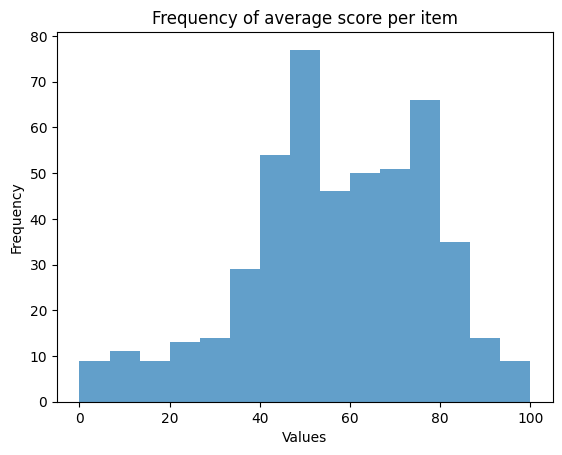

Mann-Whitney-U test
dict_keys(['obj_10', 'average', 'obj_2', 'obj_4', 'obj_7', 'obj_1', 'obj_6', 'lowest', 'obj_5', 'obj_11', 'obj_8', 'obj_3', 'obj_9'])
For obj_10, U-statistic is 34713.50 and the p-value is 0.00
For average, U-statistic is 34887.50 and the p-value is 0.00
For obj_2, U-statistic is 33379.00 and the p-value is 0.01
For obj_4, U-statistic is 34798.00 and the p-value is 0.00
For obj_7, U-statistic is 33421.00 and the p-value is 0.01
For obj_1, U-statistic is 33375.50 and the p-value is 0.01
For obj_6, U-statistic is 34953.00 and the p-value is 0.00
For lowest, U-statistic is 34778.50 and the p-value is 0.00
For obj_5, U-statistic is 32936.00 and the p-value is 0.01
For obj_11, U-statistic is 33794.00 and the p-value is 0.00
For obj_8, U-statistic is 35369.00 and the p-value is 0.00
For obj_3, U-statistic is 34584.50 and the p-value is 0.00
For obj_9, U-statistic is 34611.50 and the p-value is 0.00
range of scores
{'obj_10': (0, 100), 'average': (0.0, 100.0), 'obj_2': (0,

,Average_true,Average_false,Difference,P-value
obj_1,63.597884,57.983871,5.614013,0.006
obj_2,77.328042,72.709677,4.618365,0.008
obj_3,66.481481,59.500000,6.981481,0.001
obj_4,58.730159,51.290323,7.439836,0.000
obj_5,58.968254,54.612903,4.355351,0.014
obj_6,61.005291,54.193548,6.811743,0.000
obj_7,56.931217,52.177419,4.753798,0.005
obj_8,67.169312,59.016129,8.153183,0.000
obj_9,42.883598,35.258065,7.625533,0.001
obj_10,63.201058,56.419355,6.781703,0.000


In [22]:
data_500 = Collection.from_json("./med_qa_first_cohere_gpt-3.5-turbo.json")
data = data_500

scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
print("\n")
print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false, df_p_val = u_test(scores_with_indicator)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
df = compare_true_false(scores_per_objective_true,scores_per_objective_false,df_p_val)
df.to_excel('table_5.xlsx', index=False)
df

### New GPT3.5 supervises Cohere

(['obj_7'], True)


Average over objectives for all items
        Average
obj_1     62.38
obj_2     62.51
obj_3     37.77
obj_4     40.47
obj_5     44.12
obj_6     39.38
obj_7     37.99
obj_8     42.74
obj_9     30.05
obj_10    40.20
obj_11    41.54




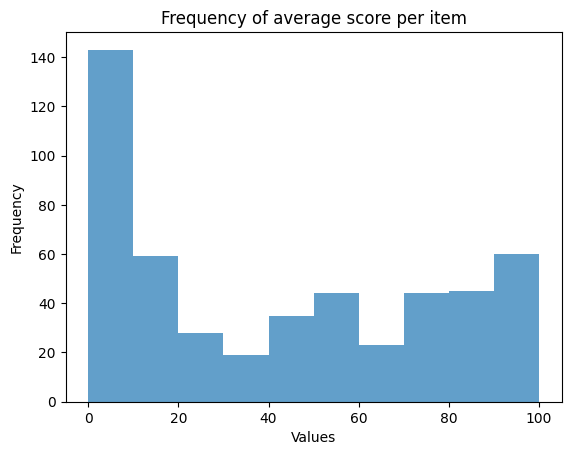

Mann-Whitney-U test
dict_keys(['obj_3', 'obj_5', 'average', 'obj_1', 'obj_10', 'obj_6', 'lowest', 'obj_9', 'obj_11', 'obj_4', 'obj_7', 'obj_8', 'obj_2'])
For obj_3, U-statistic is 34841.00 and the p-value is 0.00
For obj_5, U-statistic is 33375.50 and the p-value is 0.01
For average, U-statistic is 34253.50 and the p-value is 0.00
For obj_1, U-statistic is 33058.50 and the p-value is 0.02
For obj_10, U-statistic is 35020.00 and the p-value is 0.00
For obj_6, U-statistic is 34403.50 and the p-value is 0.00
For lowest, U-statistic is 34712.00 and the p-value is 0.00
For obj_9, U-statistic is 34648.00 and the p-value is 0.00
For obj_11, U-statistic is 34404.00 and the p-value is 0.00
For obj_4, U-statistic is 34002.00 and the p-value is 0.00
For obj_7, U-statistic is 34037.50 and the p-value is 0.00
For obj_8, U-statistic is 35305.50 and the p-value is 0.00
For obj_2, U-statistic is 32080.00 and the p-value is 0.07
range of scores
{'obj_3': (0, 100), 'obj_5': (0, 100), 'average': (0.0, 10

,Average_true,Average_false,Difference,P-value
obj_1,66.878307,59.646302,7.232005,0.015
obj_2,65.370370,60.771704,4.598666,0.073
obj_3,45.767196,32.909968,12.857228,0.000
obj_4,46.957672,36.527331,10.430341,0.002
obj_5,48.809524,41.270096,7.539427,0.009
obj_6,46.243386,35.209003,11.034383,0.001
obj_7,44.417989,34.083601,10.334388,0.002
obj_8,51.375661,37.491961,13.883700,0.000
obj_9,37.539683,25.498392,12.041290,0.000
obj_10,48.227513,35.321543,12.905970,0.000


In [16]:
data = Collection.from_json("./med_qa_first_cohere_gpt-3.5-turbo-0613.json")

scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
print("\n")
print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false, df_p_val = u_test(scores_with_indicator)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
df = compare_true_false(scores_per_objective_true,scores_per_objective_false,df_p_val)
df.to_excel('table_3.xlsx', index=False)
df

### Cohere supervised by GPT-4

(['obj_9'], True)


Average over objectives for all items
        Average
obj_1     90.16
obj_2     59.92
obj_3     87.06
obj_4     57.10
obj_5     57.49
obj_6     60.54
obj_7     51.20
obj_8     52.53
obj_9     44.88
obj_10    65.55
obj_11    65.08




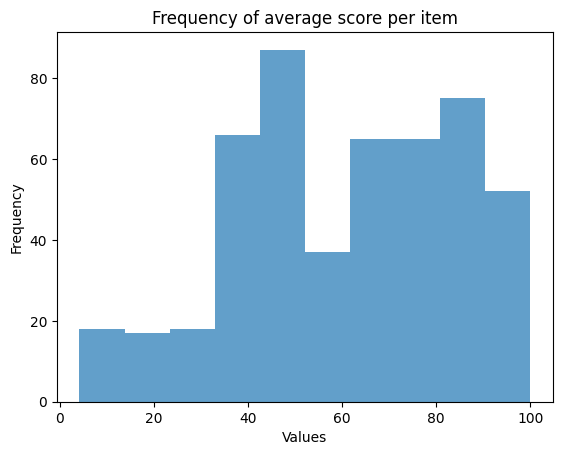

Mann-Whitney-U test
dict_keys(['obj_10', 'average', 'obj_2', 'obj_4', 'obj_7', 'obj_1', 'obj_6', 'lowest', 'obj_5', 'obj_11', 'obj_8', 'obj_3', 'obj_9'])
For obj_10, U-statistic is 44210.50 and the p-value is 0.00
For average, U-statistic is 45323.50 and the p-value is 0.00
For obj_2, U-statistic is 43496.50 and the p-value is 0.00
For obj_4, U-statistic is 44465.50 and the p-value is 0.00
For obj_7, U-statistic is 42098.00 and the p-value is 0.00
For obj_1, U-statistic is 37075.00 and the p-value is 0.00
For obj_6, U-statistic is 44020.00 and the p-value is 0.00
For lowest, U-statistic is 44777.50 and the p-value is 0.00
For obj_5, U-statistic is 39391.50 and the p-value is 0.00
For obj_11, U-statistic is 43044.50 and the p-value is 0.00
For obj_8, U-statistic is 46422.00 and the p-value is 0.00
For obj_3, U-statistic is 33205.50 and the p-value is 0.00
For obj_9, U-statistic is 41495.00 and the p-value is 0.00
range of scores
{'obj_10': (0, 100), 'average': (4.545454545454546, 100.0)

,Average_true,Average_false,Difference,P-value
obj_1,93.544974,88.102894,5.442080,0.000
obj_2,71.216931,53.054662,18.162269,0.000
obj_3,92.222222,83.922830,8.299393,0.001
obj_4,71.798942,48.167203,23.631739,0.000
obj_5,66.164021,52.218650,13.945372,0.000
obj_6,73.968254,52.379421,21.588833,0.000
obj_7,62.433862,44.372990,18.060872,0.000
obj_8,71.984127,40.707395,31.276731,0.000
obj_9,61.111111,35.016077,26.095034,0.000
obj_10,79.259259,57.218650,22.040610,0.000


In [24]:
data_500 = Collection.from_json("./med_qa_first_cohere_gpt-4.json")

data = data_500

scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=2,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
print("\n")
print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false, df_p_val = u_test(scores_with_indicator)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
df = compare_true_false(scores_per_objective_true,scores_per_objective_false,df_p_val)
df.to_excel('table_6.xlsx', index=False)
df